## Conservative Dynamics

### Semi-analytic Equations of Motion

Import `rebound` and `celmech` packages as well as other packages:

In [1]:
import rebound as rb
import celmech as cm
import scipy
import numpy as np
import matplotlib.pyplot as plt
import radvel
import pandas as pd

# make font bigger
plt.rc('font', size=16)

Import data:

In [2]:
hd_data = pd.read_csv('hd45364_rvs.csv', sep =';')
hd_data.BJD -= 2.4e6

Params:

In [3]:
#Least squares fit: 
fit_params = [ 2.28513053e+02, 7.27743508e+00, 5.39371890e+04, -1.78110513e-01, 
              -4.66450116e-02, 3.43378023e+02, 1.78603199e+01, 5.40186750e+04,
               1.32165040e-01, 9.73129308e-02, -5.29039776e-01] 

# star mass, g and auday to m/s conversion factor
STAR_MASS = 920  # 920 jupiter masses
G = 2.825e-7  # converting G to jupiter masses, au, and days
AUDAY_MS = 1.731e6  # conversion factor for au/day to m/s

Get sim using least squares params:

In [4]:
def mass_to_semiamp(planet_mass, star_mass, period, eccentricity, inclination):
    """
    planet mass (jupiter masses) to semi amplitude
    """
    return ((2 * np.pi * G/period) ** (1/3) * (planet_mass * np.sin(inclination) / star_mass ** (2/3)) * (1/np.sqrt(1 - eccentricity ** 2)))

def semiamp_to_mass(semiamp, star_mass, period, eccentricity, inclination):
    """
    semi amplitude to planet mass (jupiter masses)
    """
    return (((2 * np.pi * G/period) ** (-1/3)) * (semiamp / np.sin(inclination)) * np.sqrt(1 - eccentricity ** 2) * (star_mass ** (2/3)))


def get_sim_from_params(params, inclination, integrator, time_base, star_mass = STAR_MASS, auday_ms = AUDAY_MS):
    """
    takes in params array, returns a rebound Simulation object with those parameters
    
    param params: numpy array of params:
    
    for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset
    params[5 * num_planets + 1] is jit
    
    param inclination: inclination of system in the observation plane (pi/2 is in the plane of the sky, 0 is edge-on)
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    param time_base: base time (to begin integration from) in the simulation
    """
    
    num_planets = int((len(params) - 1) / 5) # -2 because there are rv_offset and jit parameters:
    
    sim = rb.Simulation()
    sim.integrator = integrator
    sim.t = time_base  # keplerian and n-body models initialized at the same time offset
    # print(sim.t)
    if integrator == 'whfast':  # if using whfast integrator, set timestep
        sim.dt = 1/50 * min(params[0::5][:-1])  # timestep is 1/20th of the shortest orbital period of any planet
        # print(sim.dt)
    sim.units = ('AU', 'Mjupiter', 'day')

    sim.add(m = star_mass)  # star mass as a constant
        
    for i in range (0, num_planets):
        # print(i)
        # planet parameters
        period = params[5*i]  # in days
        semiamp = params[5*i + 1] / auday_ms # divide by auday_ms because semiamp given in m/s
        eccentricity = params[5*i + 3] ** 2 + params[5*i + 4] ** 2  # eccentricity from secos, sesin
        omega = np.arctan2(params[5*i + 3], params[5*i + 4])  # omega from arctan of sesin, secos
        # get tp by converting from tc
        tp = radvel.orbit.timetrans_to_timeperi(params[5*i + 2], per = period, ecc = eccentricity, omega = omega)
        
        # mass
        mass = semiamp_to_mass(semiamp = semiamp, star_mass = star_mass, period = period, eccentricity = eccentricity, inclination = inclination)
        
        # adding to simulation
        sim.add(m = mass, P = period, e = eccentricity, T = tp, omega = omega, inc = inclination)
        
    sim.move_to_com()  # move to center of mass
    
    return sim


Create sim from params:

In [28]:
time_base = np.median(hd_data.BJD)
sim = get_sim_from_params(fit_params, inclination = np.pi/2, integrator = 'ias15', time_base = 0)
cm.nbody_simulation_utilities.align_simulation(sim)

Construct Hamiltonian for the system:

In [29]:
pvars = cm.Poincare.from_Simulation(sim)
pham = cm.PoincareHamiltonian(pvars)
pham.H

-G**2*M2**2*mu2**3/(2*Lambda2**2) - G**2*M1**2*mu1**3/(2*Lambda1**2)

Now add eccentricity MMR terms:

In [30]:
pham.add_eccentricity_MMR_terms(3, 1, max_order=3)
pham.H

-C_3,-2,-1,0,0,0^0,0,0,0;(1,2)*G**2*M2*m1*m2*mu2**2*(eta1*sin(2*lambda1 - 3*lambda2)/sqrt(Lambda1) + kappa1*cos(2*lambda1 - 3*lambda2)/sqrt(Lambda1))/Lambda2**2 - C_3,-2,-1,0,0,0^0,0,0,1;(1,2)*G**2*M2*m1*m2*mu2**2*(eta2**2 + kappa2**2)*(eta1*sin(2*lambda1 - 3*lambda2)/sqrt(Lambda1) + kappa1*cos(2*lambda1 - 3*lambda2)/sqrt(Lambda1))/Lambda2**3 - C_3,-2,-1,0,0,0^0,0,1,0;(1,2)*G**2*M2*m1*m2*mu2**2*(eta1**2 + kappa1**2)*(eta1*sin(2*lambda1 - 3*lambda2)/sqrt(Lambda1) + kappa1*cos(2*lambda1 - 3*lambda2)/sqrt(Lambda1))/(Lambda1*Lambda2**2) - C_3,-2,-1,0,0,0^0,1,0,0;(1,2)*G**2*M2*m1*m2*mu2**2*(rho2**2/2 + sigma2**2/2)*(eta1*sin(2*lambda1 - 3*lambda2)/sqrt(Lambda1) + kappa1*cos(2*lambda1 - 3*lambda2)/sqrt(Lambda1))/(2*Lambda2**3) - C_3,-2,-1,0,0,0^1,0,0,0;(1,2)*G**2*M2*m1*m2*mu2**2*(rho1**2/2 + sigma1**2/2)*(eta1*sin(2*lambda1 - 3*lambda2)/sqrt(Lambda1) + kappa1*cos(2*lambda1 - 3*lambda2)/sqrt(Lambda1))/(2*Lambda1*Lambda2**2) - C_3,-2,0,-1,0,0^0,0,0,0;(1,2)*G**2*M2*m1*m2*mu2**2*(eta2*sin(2*lamb

Now we want to compare $\theta_1$, $\theta_2$, $e_1$, $e_2$ and $P_2/P_1$ so we integrate over a series of times starting at `time_base`:

In [31]:
# inner and outer particles for rebound versus celmech

inner_rb = sim.particles[1]
outer_rb = sim.particles[2]
inner_cm = pvars.particles[1]
outer_cm = pvars.particles[2]

# defining times
Nout = 1000  # 1000 values
times = np.linspace(0, 0 + 300, Nout) * inner_rb.P  # 3000 times the orbital period of teh inner planet
# defining parameters of interest
l1_rb, l2_rb, pomega1_rb, pomega2_rb, e1_rb, e2_rb, p1_rb, p2_rb = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
l1_cm, l2_cm, pomega1_cm, pomega2_cm, e1_cm, e2_cm, p1_cm, p2_cm = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout) 

Performing the integration and recording all the paramters required:

In [32]:
for i,t in enumerate(times):
    sim.integrate(t) # advance N-body
    pham.integrate(t) # advance celmech
    # mean longitude angles
    l1_rb[i] = inner_rb.l
    l2_rb[i] = outer_rb.l
    l1_cm[i] = inner_cm.l
    l2_cm[i] = outer_cm.l
    # pomegas
    pomega1_rb[i] = inner_rb.pomega
    pomega2_rb[i] = outer_rb.pomega
    pomega1_cm[i] = inner_cm.pomega
    pomega2_cm[i] = outer_cm.pomega
    # eccentricities
    e1_rb[i] = inner_rb.e
    e2_rb[i] = outer_rb.e
    e1_cm[i] = inner_cm.e
    e2_cm[i] = outer_cm.e
    # periods
    p1_rb[i] = inner_rb.P
    p2_rb[i] = outer_rb.P
    p1_cm[i] = inner_cm.P
    p2_cm[i]= outer_cm.P

Compute period ratio and resonant angles $\theta_i$:

In [33]:
# period ratio
pr_rb, pr_cm = p2_rb/p1_rb, p2_cm/p1_cm
# resonant angles
theta1_rb, theta1_cm = np.mod(3 * l2_rb - 2 * l1_rb - pomega1_rb, 2 * np.pi), np.mod(3 * l2_cm - 2 * l1_cm - pomega1_cm, 2 * np.pi)
theta2_rb, theta2_cm = np.mod(3 * l2_rb - 2 * l1_rb - pomega2_rb, 2 * np.pi), np.mod(3 * l2_cm - 2 * l1_cm - pomega2_cm, 2 * np.pi)

Plotting:

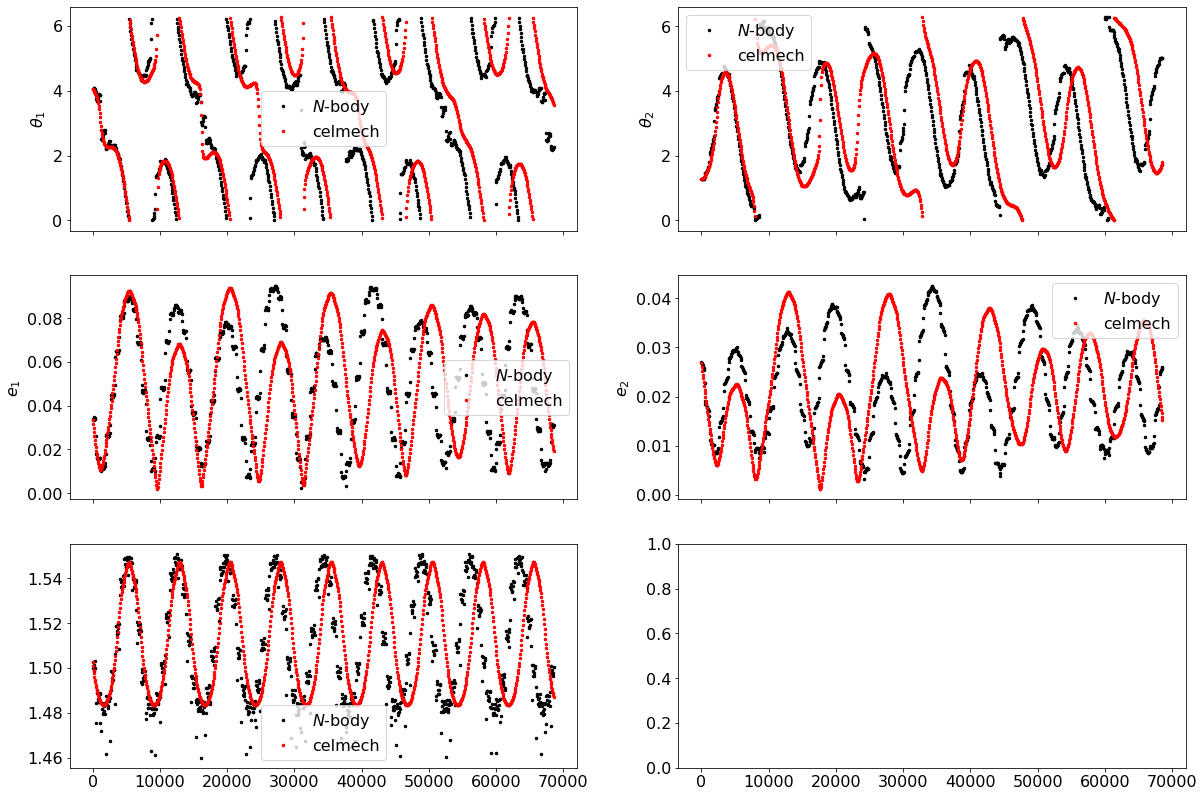

In [34]:
# Plotting:
fig, ((ax_theta1, ax_theta2), (ax_e1, ax_e2), (ax_pr, _ )) = plt.subplots(3, 2, sharex=True, figsize = (20, 14))
# theta1
ax_theta1.plot(times, theta1_rb, 'k.', label = r'$N$-body')
ax_theta1.plot(times, theta1_cm, 'r.', label = r'celmech')
ax_theta1.legend()
ax_theta1.set_ylabel(r'$\theta_1$')
# theta2
ax_theta2.plot(times, theta2_rb, 'k.', label = r'$N$-body')
ax_theta2.plot(times, theta2_cm, 'r.', label = r'celmech')
ax_theta2.legend()
ax_theta2.set_ylabel(r'$\theta_2$')
# e1
ax_e1.plot(times, e1_rb, 'k.', label = r'$N$-body')
ax_e1.plot(times, e1_cm, 'r.', label = r'celmech')
ax_e1.legend()
ax_e1.set_ylabel(r'$e_1$')
# e2
ax_e2.plot(times, e2_rb, 'k.', label = r'$N$-body')
ax_e2.plot(times, e2_cm, 'r.', label = r'celmech')
ax_e2.legend()
ax_e2.set_ylabel(r'$e_2$')
# period ratio
ax_pr.plot(times, pr_rb, 'k.', label = r'$N$-body')
ax_pr.plot(times, pr_cm, 'r.', label = r'celmech')
ax_pr.legend()